# Assignment 8 - Convolutional Neural Networks

Congratulations! You have made it to the last assignment of the TechX Machine Learning bootcamp. In the following assignment, you will explore with convolutional neural networks (CNNs) by training a classifier to recognize the difference between images of cats and dogs. The training time of this assignment will take longer than previous ones, so it reccommended to run this on a GPU.

Start by downloading the dataset and unzipping to your local environment: [https://techx.blob.core.windows.net/cats-and-dogs/dataset.zip](https://techx.blob.core.windows.net/cats-and-dogs/dataset.zip)

### Import Libraries

As usual, let's start by importing the necessary libaries.

In [8]:
from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import activations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

%matplotlib inline


### Helper Methods
Below are some helper methods that have been created for usage later in the assignment.

In [9]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['acc'])
    acc = smooth_curve(history.history['acc'][:steps])
    val_acc = smooth_curve(history.history['val_acc'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

### Question 1: Load Data and Prepare Data

When it comes to CNNs, we are usually working with data that takes up a large amount of space which means we will need to load the data in batches. You'll also notice that the dataset only has 1500 images for each class, which is not nearly enough data to train an accurate classifier using a deep neural network approach. As a result, we will need to augment our data as well - perform linear transformations on the existing data in order to create additional new data.

Luckily, there is [built in functionality in keras](https://keras.io/preprocessing/image/) to help us load our data in batches while augmenting it in real-time. Let's start by using this library to load and prepare our data.

#### Start by setting the root path of your dataset:

In [10]:
## ========== YOUR CODE HERE ========= ##
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#### Create instances of the ImageDataGenerator object for the train and test data with the following parameters:
1) Train data:
- Rescale: 1./255
- Rotation Range: 40
- Width Shift Range: 0.2
- Height Shift Range: 0.2
- Shear Range: 0.2
- Zoom Range: 0.2
- Horizontal Flip: True

2) Test data:
- Rescale: 1./255

#### Use the online documentation for support.

In [14]:
## ========== YOUR CODE HERE ========= ##
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

#### Set the directory, target size (150,150), batch size (32), and class mode (binary) on the data generator instances using the .flow_from_directory method. 

In [17]:
## ========== YOUR CODE HERE ========= ##
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Question 2: Build and Train Custom Model
Now that our data is ready, it is time to start training our model. This section will first go over an example of how to build a custom CNN architecture and train our data on this model. Then you will be given the outline for another custom architecture which you will have to build and train by yourself. 

#### For the first custom model, we will create and compile a sequential model with the following architecture
- Convolution layer with 32 filters, 3x3 kernel, relu activation, and padding
- Max pooling layer with a size of 2x2
- Flattening layer
- Densely connected output layer with dimension of 1 and sigmoid activation function

In [18]:
# create the model defined above
model_custom1 = Sequential()
model_custom1.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model_custom1.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_custom1.add(Flatten())
model_custom1.add(Dense(1, activation='sigmoid', name='output'))

# compile the model
model_custom1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


#### We can print a summary of the architecture as shown below

In [19]:
model_custom1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 180000)            0         
_________________________________________________________________
output (Dense)               (None, 1)                 180001    
Total params: 180,897
Trainable params: 180,897
Non-trainable params: 0
_________________________________________________________________


#### We can now train and save the model.

In [20]:
# train model for 50 epochs, with 100 steps per epoch, and 50 validation steps
history_custom1 = model_custom1.fit_generator(train_generator, steps_per_epoch=100, epochs=50, 
                                      validation_data=validation_generator, validation_steps=50, verbose=1)

# save the model and its history
model_custom1.save('model-custom1.h5')
save_history(history_custom1, 'history_custom1.bin')

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
100/100 [==============================] - 34s 337ms/step - loss: 0.8797 - acc: 0.5563 - val_loss: 0.6430 - val_acc: 0.6034
Epoch 2/50
100/100 [==============================] - 33s 329ms/step - loss: 0.6495 - acc: 0.6134 - val_loss: 0.6179 - val_acc: 0.6624
Epoch 3/50
100/100 [==============================] - 33s 334ms/step - loss: 0.6483 - acc: 0.6175 - val_loss: 0.6213 - val_acc: 0.6288
Epoch 4/50
100/100 [==============================] - 33s 328ms/step - loss: 0.6390 - acc: 0.6288 - val_loss: 0.6046 - val_acc: 0.6553
Epoch 5/50
100/100 [==============================] - 33s 333ms/step - loss: 0.6238 - acc: 0.6525 - val_loss: 0.6292 - val_acc: 0.6548
Epoch 6/50
100/100 [==============================] - 33s 333ms/step - loss: 0.6374 - acc: 0.6288 - val_loss: 0.5994 - val_acc: 0.6759
Epoch 7/50
100/100 [==============================] - 33s 330ms/step - loss: 0.6255 - acc: 0.6456 - val_loss: 0.6001 - val_acc: 0.6821
Epoch 8

#### Then plot the results.

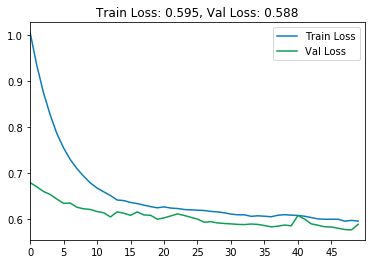

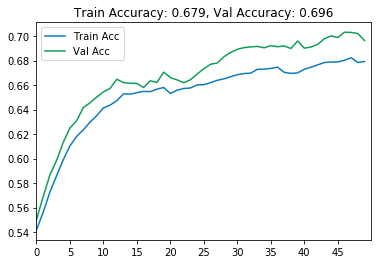

In [11]:
# plot results
history_custom1 = load_history('history_custom1.bin')
plot_compare(history_custom1)

#### Now it's your turn! Build a new custom model with the following architecture: 
- Convolution layer with 32 filters, 3x3 kernel, relu activation, and padding
- Max pooling layer with a size of 2x2
- Convolution layer with 64 filters, 3x3 kernel, relu activation, and padding
- Max pooling layer with a size of 2x2
- Convolution layer with 128 filters, 3x3 kernel, relu activation, and padding
- Max pooling layer with a size of 2x2
- Convolution layer with 128 filters, 3x3 kernel, relu activation, and padding
- Max pooling layer with a size of 2x2
- Flattening layer
- Dropout layer with 0.5 dropout rate
- Densely connected layer with dimension of 512 and relu activation function
- Densely connected layer with dimension of 256 and relu activation function
- Densely connected output layer with dimension of 1 and sigmoid activation function

#### Follow the same method as above and plot the results afterwards.

In [ ]:
## ========== YOUR CODE HERE ========= ##

# create the model defined above
model_custom2 = Sequential()
model_custom2.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model_custom2.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_custom2.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_custom2.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_custom2.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_custom2.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_custom2.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_custom2.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_custom2.add(Flatten())
model_custom2.add(Dropout(0.5))
model_custom2.add(Dense(512, activation='relu', name='dense_1'))
model_custom2.add(Dense(256, activation='relu', name='dense_2'))
model_custom2.add(Dense(1, activation='sigmoid', name='output'))

# compile the model
model_custom2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model for 50 epochs, with 100 steps per epoch, and 50 validation steps
history_custom2 = model_custom2.fit_generator(train_generator, steps_per_epoch=100, epochs=50, 
                                      validation_data=validation_generator, validation_steps=50, verbose=1)

# save the model and its history
model_custom2.save('model-custom2.h5')
save_history(history_custom2, 'history_custom2.bin')

# plot results
history_custom2 = load_history('history_custom2.bin')
plot_compare(history_custom2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/50
100/100 [==============================] - 66s 655ms/step - loss: 0.6995 - acc: 0.5122 - val_loss: 0.6916 - val_acc: 0.5190
Epoch 2/50
100/100 [==============================] - 65s 645ms/step - loss: 0.6917 - acc: 0.5122 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 3/50
100/100 [==============================] - 64s 636ms/step - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6907 - val_acc: 0.4956
Epoch 4/50
100/100 [==============================] - 67s 670ms/step - loss: 0.6895 - acc: 0.5322 - val_loss: 0.6845 - val_acc: 0.5696
Epoch 5/50
100/100 [==============================] - 66s 656ms/step - loss: 0.6719 - acc: 0.5644 - val_loss: 0.6672 - val_acc: 0.5888
Epoch 6/50
100/100 [==============================] - 65s 653ms/step - loss: 0.6550 - acc: 0.5953 - val_loss: 0.6715 - val_acc: 0.5541
Epoch 7/50
100/100 [==============================] - 64s 639ms/step - loss

#### Which of the two custom models performed better? What do you think contributed to the better performance? How do you think you could improve the model even more?

In [17]:
## ========== YOUR ANSWER HERE ========= ##

### Question 3: Explore On Your Own!

#### Use your proposed methods in the previous question to try and improve the performance of the model. 

In [19]:
## ========== YOUR CODE HERE ========= ##

# Train your own custom model here. 